Best parameters: {'max_iter': 5000, 'loss': 'squared_hinge', 'C': 100}
Best accuracy: 0.6469
Accuracy: 0.5798
Precision: 0.1278
Recall: 0.7146
F1 Score: 0.2168
AUC-ROC: 0.6412


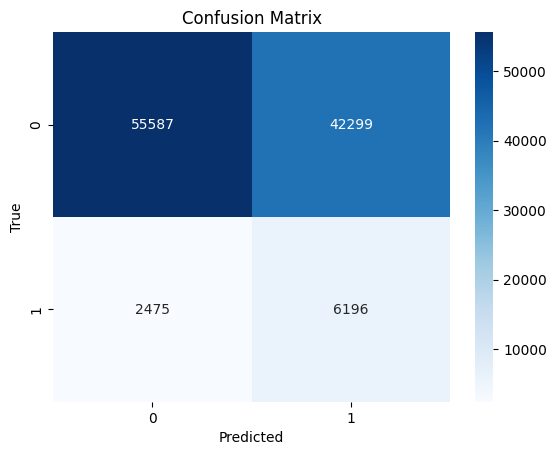

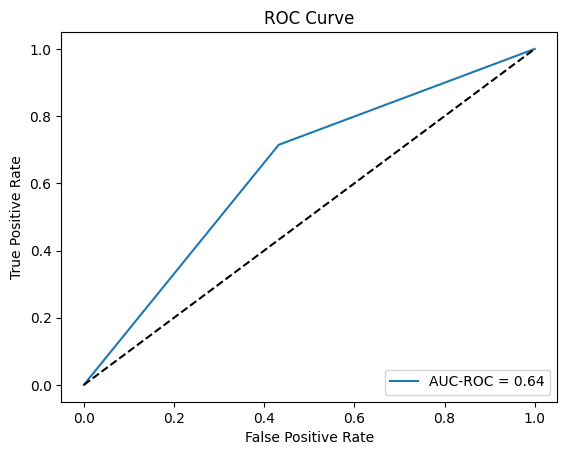

The file 'dev/final/model_c/model.pkl' has been successfully uploaded to the S3 bucket 'introtoaiwinter24'.
The file 'dev/final/model_c/model.tar.gz' has been successfully uploaded to the S3 bucket 'introtoaiwinter24'.


In [2]:

# !pip install pandas sagemaker boto3 botocore numpy matplotlib seaborn scikit-learn nbconvert
# !pip install imbalanced-learn lime shap


# Import necessary packages
import pandas as pd
import boto3
import json
import botocore
import sagemaker
from sagemaker.sklearn.model import SKLearnModel
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import shap
from lime import lime_tabular
import os
import shutil
import tarfile

from sklearn.svm import LinearSVC


# Define the S3Utils class for S3 operations

class S3Utils:
    def __init__(self, secret_name_or_arn, file_path=None):
        self.secret_name_or_arn = secret_name_or_arn
        self.file_path = file_path
        if file_path:
            self.aws_access_key_id, self.aws_secret_access_key, self.bucket_name = self.get_aws_credentials_from_file()
        else:
            self.aws_access_key_id, self.aws_secret_access_key, self.bucket_name = self.get_aws_credentials_from_secrets_manager()
        self.s3_client = self.create_s3_client()

    def get_aws_credentials_from_secrets_manager(self):
        client = boto3.client(service_name='secretsmanager')
        get_secret_value_response = client.get_secret_value(SecretId=self.secret_name_or_arn)
        secret_dict = json.loads(get_secret_value_response['SecretString'])
        return secret_dict['aws_access_key_id'], secret_dict['aws_secret_access_key'], secret_dict['bucket_name']

    def get_aws_credentials_from_file(self):
        credentials_df = pd.read_csv(self.file_path)
        return credentials_df['aws_access_key_id'].iloc[0], credentials_df['aws_secret_access_key'].iloc[0], credentials_df['bucket_name'].iloc[0]

    def create_s3_client(self):
        return boto3.client(
            's3',
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key
        )

    def check_and_transfer_file(self, source_key, destination_key):
        try:
            self.s3_client.head_object(Bucket=self.bucket_name, Key=destination_key)
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                self.s3_client.copy_object(
                    Bucket=self.bucket_name,
                    CopySource=f"{self.bucket_name}/{source_key}",
                    Key=destination_key
                )
            else:
                raise e

    def check_file_exists(self, file_key):
        try:
            self.s3_client.head_object(Bucket=self.bucket_name, Key=file_key)
            return True
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                return False
            else:
                raise e

    def read_csv_from_s3(self, file_key):
        obj = self.s3_client.get_object(Bucket=self.bucket_name, Key=file_key)
        return pd.read_csv(obj['Body'])

    def write_csv_to_s3(self, file_key, df):
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        self.s3_client.put_object(
            Bucket=self.bucket_name,
            Key=file_key,
            Body=csv_buffer.getvalue()
        )
    
    def upload_file(self, file_key, file_path):
        try:
            self.s3_client.upload_file(file_path, self.bucket_name, file_key)
            print(f"The file '{file_key}' has been successfully uploaded to the S3 bucket '{self.bucket_name}'.")
        except botocore.exceptions.ClientError as e:
            print(f"Failed to upload file '{file_key}' to S3 bucket '{self.bucket_name}'. Error: {e}")
        


        
# # Set the path to S3 AWS credentials file
# Using credentials from a file
s3_utils = S3Utils(secret_name_or_arn=None, file_path="C:/churn/bucketcredentials.csv")

# Initialize S3Utils using credentials from Secrets Manager
#s3_utils = S3Utils(secret_name_or_arn="arn:aws:secretsmanager:us-east-2:767397996410:secret:dev/s3/bucket_token-6t6xMP")

# Define your parameters
env = "dev"  # dev, test, staging, prod
mainsource = "SourceDataSet/bank_data_train.csv"
envraw = f'{env}/raw/bank_data_train.csv'

# Always check if the Raw SourceCode exists, if so, copy the file to raw on a specific environment
s3_utils.check_and_transfer_file(mainsource, envraw)

# Read the raw data from the S3 bucket
input_file_key_data_cleaning = f'{env}/raw/bank_data_train.csv'

# Output file keys for various stages of the pipeline
output_file_key_data_cleaning = f'{env}/processed/bank_data_cleaned.csv'
output_file_key_data_visualization = f'{env}/processed/bank_data_visualization.csv'
output_file_key_data_feature_engineering = f'{env}/final/bank_data_feature_eng.csv'
output_file_key_data_X_train = f'{env}/final/model_one/X_train.csv'
output_file_key_data_X_test = f'{env}/final/model_one/X_test.csv'
output_file_key_data_Y_train = f'{env}/final/model_one/Y_train.csv'
output_file_key_data_Y_test = f'{env}/final/model_one/Y_test.csv'
output_file_key_data_svm_model_pkl = f'{env}/final/model_c/model.pkl'
output_file_key_data_svm_model_tar = f'{env}/final/model_c/model.tar.gz'

# Ensure all columns are displayed in Jupyter
pd.set_option('display.max_columns', None)

# Load the dataset from S3
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

# Data preprocessing steps
X = dataset.drop('target', axis=1)
y = dataset['target']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train the SVM model using LinearSVC
linearsvc_model = LinearSVC(class_weight='balanced', dual=False, random_state=42)
linearsvc_param_distributions = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'loss': ['squared_hinge'],  # Loss function
    'max_iter': [1000, 5000, 10000]  # Maximum number of iterations
}

# Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    linearsvc_model,
    param_distributions=linearsvc_param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best roc_auc: {best_score:.4f}")

# Retrain the model using the best hyperparameters on the resampled training data
linearsvc_model.set_params(**best_params)
linearsvc_model.fit(X_resampled, y_resampled)

# Make predictions using the retrained model on the test data
y_pred = linearsvc_model.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save the model to a .pkl file
joblib.dump(linearsvc_model, 'model.pkl')

# Upload the model.pkl file to S3
s3_utils.upload_file(output_file_key_data_svm_model_pkl, 'model.pkl')

# Create the directory
model_dir = 'model_dir'
os.makedirs(model_dir, exist_ok=True)

# Move the model.pkl file into the directory
shutil.move('model.pkl', os.path.join(model_dir, 'model.pkl'))

# Create a tar.gz archive of the model_dir directory
with tarfile.open('model.tar.gz', 'w:gz') as tar:
    tar.add(model_dir, arcname=os.path.basename(model_dir))

# Upload the model.tar.gz file to S3
s3_utils.upload_file(output_file_key_data_svm_model_tar, 'model.tar.gz')